# Build and Evaluate Models

Pre-Processing
*   SMOTE
*   Normalize

Models
* Logistic Regression
* Linear SVC
* KNeighborhs 
* Random Forest

In [116]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import datetime
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [14]:
features_s = pd.read_csv("clean_data/features_s.csv").iloc[:,1:]
features_m = pd.read_csv("clean_data/features_m.csv").iloc[:,1:]
features = pd.read_csv("clean_data/features.csv").iloc[:,1:]
outcomes = pd.read_csv("clean_data/outcomes.csv").iloc[:,1:]

## SMOTE

In [15]:
smote = SMOTE()

def smote_col(col, feats):
  '''
  SMOTE (balance binary classes)
  for an outcome column in df
  based on inputted features df
  '''
  x_smote, y_smote = smote.fit_resample(feats.astype(float), outcomes[col])
  
  x_smote = pd.DataFrame(x_smote)
  x_smote.columns = feats.columns

  y_smote = pd.DataFrame(y_smote)
  y_smote.columns = [col]

  return x_smote, y_smote

#smote each feature set
feature_sets = {"features": features, 
                "features_m": features_m,
                "features_s": features_s}

smotes = {}
for time in ["1Y", "5Y"]:
  for measure in ["Median", "75th"]: 
    for feat_set, features in feature_sets.items() :
      var = "Gentrified " + time + " " + measure
      x, y = smote_col(var, features)
      smotes[var] = smotes.get(var, {}) 
      smotes[var][feat_set] = {"X": x, "y": y}  

## Pipeline

In [17]:
# --- Grid Search --- # 
def grid_search(X_train, X_test, y_train, y_test, models, parameters, time, measure, feat_set):
    """
    Looks for the best model based off a list of models and their parameters
    """    
    # Begin timer 
    start = datetime.datetime.now()

    # Initialize results data frame 
    results = []

    # Loop over models 
    for model_key in models.keys(): 

        # Loop over parameters 
        for params in parameters[model_key]: 
            print("Training model:", model_key, "|", params)
            
            # Create model 
            model = models[model_key]
            model.set_params(**params)
            #print("Model:", model)
            
            # Normalize Features
            new_model = Pipeline([('scaler', StandardScaler()), ('model', model)])

            # Fit model on training set 
            new_model.fit(X_train, y_train.values.ravel())
            
            # Predict on testing set 
            y_hat = new_model.predict(X_test)
            
            # Evaluate predictions 
            mse_acc = metrics.accuracy_score(y_test, y_hat)
            mse_prec = metrics.precision_score(y_test, y_hat)
            mse_recall = metrics.recall_score(y_test, y_hat)
            mse_f1 = metrics.f1_score(y_test, y_hat)
            
            # Store results in your results data frame 
            result = [time, measure, feat_set, model_key,params,mse_acc,mse_prec,mse_recall,mse_f1]
            #print(result)
            results.append(result)
            
    # End timer
    stop = datetime.datetime.now()
    print("Time Elapsed:", stop - start) 
    return results
       

In [18]:
# Config: Dictionaries of models and hyperparameters
models = {
    'LogisticRegression': LogisticRegression(), 
    'LinearSVC': LinearSVC(), 
    'KNeighbors': KNeighborsClassifier(), 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
}

grid = {
    'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0, 'max_iter': 5000} 
                           for x in ('l2', 'none') \
                           for y in (0.01, 0.1, 1, 10, 100)],
    'LinearSVC': [{'C': x, 'random_state': 0, 'dual': False} \
                  for x in (0.01, 0.1, 1, 10, 100)],
    'KNeighbors': [{'n_neighbors':x, "weights":y, "metric":z} \
                   for x in (3,5,11,19) \
                   for y in ('uniform','distance') \
                   for z in ('euclidean','manhattan')], 
    'DecisionTree': [{'criterion':x, "max_depth":y, "min_samples_split":z} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10)],
    'RandomForest': [{'criterion':x, "max_depth":y, "min_samples_split":z, "n_estimators":a} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10) \
                   for a in (100,1000,5000)]
}

full_results = pd.DataFrame(columns=['Outcome Timeframe', 
                                     'Outcome Benchmark',
                                     'Feature Set',
                                     'Model',
                                     'Parameters', 
                                     'Accuracy',
                                     'Precision',
                                     'Recall',
                                     'F1 Score'])

#run grid search on each outcome and feature set
for time in ["1Y", "5Y"]:
    for feat_set, features in feature_sets.items() :
      var = "Gentrified " + time + " Median"
      X_train, X_test, y_train, y_test = train_test_split(smotes[var][feat_set]["X"], 
                                                          smotes[var][feat_set]["y"], 
                                                          test_size=0.2,
                                                          random_state=0)
      results = grid_search(X_train, X_test, y_train, y_test, 
                            models, grid, time, "Median", feat_set)
      results_df = pd.DataFrame(results, columns=['Outcome Timeframe', 
                                    'Outcome Benchmark',
                                    'Feature Set',
                                    'Model',
                                    'Parameters', 
                                    'Accuracy',
                                    'Precision',
                                    'Recall',
                                    'F1 Score'])
      full_results = full_results.append(results_df)

Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.01, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 10, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 0.01, 'random_state': 0, 'max_iter': 5000}


/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}


/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights'

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 

/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}


/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}
Training mode

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 

/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_nei

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 

/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 

/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 

/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/carolinekinnen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 5, 'weights': 'unifor

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 

In [122]:
full_results[(full_results["Outcome Timeframe"] == "1Y") & 
             (full_results["Outcome Benchmark"] == "Median")].sort_values(["Accuracy", "Precision"], 
                                                                          ascending = False).head(50)

,Outcome Timeframe,Outcome Benchmark,Feature Set,Model,Parameters,Accuracy,Precision,Recall,F1 Score
18,1Y,Median,features_m,KNeighbors,"{'n_neighbors': 3, 'weights': 'distance', 'met...",0.864662,0.809524,0.971429,0.883117
22,1Y,Median,features_m,KNeighbors,"{'n_neighbors': 5, 'weights': 'distance', 'met...",0.864662,0.809524,0.971429,0.883117
18,1Y,Median,features,KNeighbors,"{'n_neighbors': 3, 'weights': 'distance', 'met...",0.857143,0.822785,0.928571,0.872483
20,1Y,Median,features_m,KNeighbors,"{'n_neighbors': 5, 'weights': 'uniform', 'metr...",0.857143,0.822785,0.928571,0.872483
17,1Y,Median,features,KNeighbors,"{'n_neighbors': 3, 'weights': 'distance', 'met...",0.849624,0.812500,0.928571,0.866667
16,1Y,Median,features,KNeighbors,"{'n_neighbors': 3, 'weights': 'uniform', 'metr...",0.842105,0.818182,0.900000,0.857143
15,1Y,Median,features,KNeighbors,"{'n_neighbors': 3, 'weights': 'uniform', 'metr...",0.842105,0.810127,0.914286,0.859060
21,1Y,Median,features,KNeighbors,"{'n_neighbors': 5, 'weights': 'distance', 'met...",0.842105,0.802469,0.928571,0.860927
22,1Y,Median,features,KNeighbors,"{'n_neighbors': 5, 'weights': 'distance', 'met...",0.842105,0.802469,0.928571,0.860927
16,1Y,Median,features_m,KNeighbors,"{'n_neighbors': 3, 'weights': 'uniform', 'metr...",0.842105,0.802469,0.928571,0.860927


## Best Model: K Nearest Neighbor

In [119]:
sorted_best1 = full_results[(full_results["Outcome Timeframe"] == "1Y") & 
             (full_results["Outcome Benchmark"] == "Median")].sort_values(["Accuracy", "Precision"], ascending = False)
print(sorted_best1.iloc[0,]['Model'])
print(sorted_best1.iloc[0,]['Parameters'])

KNeighbors
{'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}


In [127]:
X_train, X_test, y_train, y_test = train_test_split(smotes["Gentrified 1Y Median"]["features_m"]["X"],
                                                    smotes["Gentrified 1Y Median"]["features_m"]["y"],
                                                    test_size=0.2,
                                                    random_state=0)
    
best_model = KNeighborsClassifier(n_neighbors = 3, 
                        weights = 'distance',
                        metric = 'manhattan')


best_model.fit(X_train, y_train.values.ravel())
            
y_pred = best_model.predict(X_test)

### Confirming Best K

In [ ]:
k_dict = {}

for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = k,
                              weights = "distance",
                              metric = "manhattan")
    
    knn.fit(X_train, y_train.values.ravel())
    pred = knn.predict(X_test)
    
    k_dict[k] = metrics.accuracy_score(y_test, pred)

Text(0, 0.5, 'Testing Accuracy')

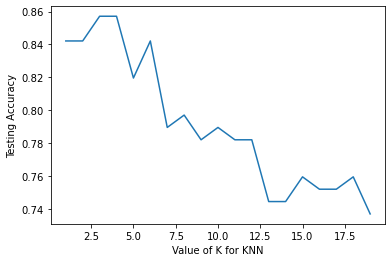

In [120]:
plt.plot(k_dict.keys(), k_dict.values())
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

### Precision Recall Curve

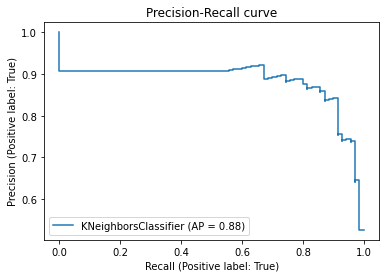

In [124]:
disp = metrics.plot_precision_recall_curve(best_model, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')

None

### Confusion Matrix

[[50 13]
 [ 6 64]]


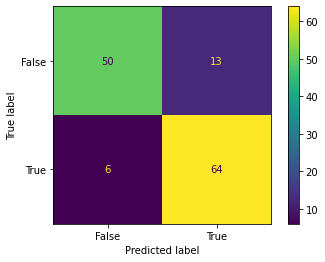

In [128]:
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

plot_confusion_matrix(best_model,X_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred))

## Explore Best Model: Random Forest

In [19]:
#1Y Median
sorted = full_results[(full_results["Outcome Timeframe"] == "1Y") & 
             (full_results["Outcome Benchmark"] == "Median")].sort_values(["Accuracy", "Precision"])
#dic = dict(sorted[-1:]["Parameters"])


X_train, X_test, y_train, y_test = train_test_split(smotes["Gentrified 1Y Median"]["features_s"]["X"],
                                                    smotes["Gentrified 1Y Median"]["features_s"]["y"],
                                                    test_size=0.2,
                                                    random_state=0)
best_model = RandomForestClassifier(n_estimators=100, 
                               random_state=0, 
                               min_samples_split=5,
                               n_jobs=-1, 
                               verbose = 1)
best_model.fit(X_train, y_train)

<ipython-input-19-1091e96c3d42>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train, y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=0,
                       verbose=1)

In [ ]:
importances = best_model.feature_importances_
index = np.arange(len(importances))
fi = plt.figure(figsize=(8,6))
fi = plt.bar(X_train.columns.values, importances)
fi = plt.xlabel('Features')
fi = plt.ylabel('Importance')
fi = plt.xticks(rotation=45, horizontalalignment='right')
fi = plt.title('Importance of Each Feature from Random Forest')
plt.show(fi)

In [ ]:
#5Y Median
full_results[(full_results["Outcome Timeframe"] == "5Y") & 
             (full_results["Outcome Benchmark"] == "Median")].sort_values("Accuracy")

#largest feature sets perform best. Decision Tree does surprisingly well.